In [1]:
%matplotlib inline

In [12]:
import hashlib
import logging
import os
import pickle
import time

import pandas as pd
import sqlalchemy

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [13]:
with open('./db_url.txt', 'r') as f:
    db_url = f.read().strip()
engine = sqlalchemy.create_engine(db_url)

In [22]:
def ttime(fn):
    def wrapper(*args, **kwargs):
        start = time.time()
        
        ret = fn(*args, **kwargs)
        
        elapsed = time.time() - start
        logger.info('Execution of {} took {:.03f} s'.format(fn.__name__, elapsed))
        
        return ret
    
    return wrapper

In [23]:
def get_from_cache(name):
    data = None
    
    try:
        with open(os.path.join('./cache', name), 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        logger.info('Cache file not found. Fetching results from redshift')

    return data


def save_to_cache(name, data):
    data = None
    
    with open(os.path.join('./cache', name), 'wb') as f:
        data = pickle.dump(data, f)

@ttime
def execute_query(query, name=None):
    if not name:
        name = hashlib.sha1(query.encode()).hexdigest()
    name += '.pickle'
    
    cached_data = get_from_cache(name)
    if cached_data:
        return cached_data
    
    data = pd.read_sql_query(query, engine)
    save_to_cache(name, data)
    return data

In [24]:
d = execute_query('''SELECT to_char((timestamp), 'YYYY-MM-DD') as day, COUNT(*) from record GROUP BY day;''')

INFO:__main__:Execution of execute_query took 0.341 s


In [27]:
d

,day,count
0,2017-08-12,6528491
1,2017-08-13,15341547
2,2017-08-15,11273238
3,2017-08-16,7568648
4,2017-08-18,5101089
5,2017-08-20,17405989
6,2017-08-21,6133772
7,2017-08-24,5556941
8,2017-08-26,10969170
9,2017-09-05,2561726


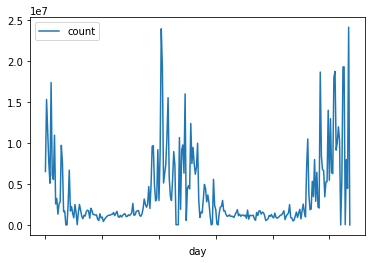

In [28]:
d.plot.line(x='day', y='count')